# Additional Topic

##  Data Augmentation

Data augmentation occurs when new data is created based on modifications of existing data.For image data specifically, data augmentation could consist of things like flipping the image horizontally or vertically, rotating the image, zooming in or out, cropping, or varying the color.

### Why we don Data Augmentation ?


Maybe we have a small training set, or maybe we just want to make our training set larger. We can do that by augmenting our existing data and then adding that data to the training set.

Another reason to use data augmentation is to reduce overfitting.


### Performing Data Augmentation In code

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

plotImages() function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.

In [2]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout

The variable gen as an ImageDataGenerator. All the parameters being passed are the different ways we’re telling Keras to augment the image.

In [3]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [4]:
chosen_image = random.choice(os.listdir('data/dogs-vs-cats/train/dog'))

create a variable called image_path and set that to the relative location on disk of the chosen image.

In [5]:
image_path = 'data/dogs-vs-cats/train/dog/' + chosen_image

Obtain the image by reading the image from disk by using plt.imread() and passing in the image_path. We also, expand the dimensions so that the image is compatible for how we’ll use it later.

In [6]:
image = np.expand_dims(plt.imread(image_path),0)

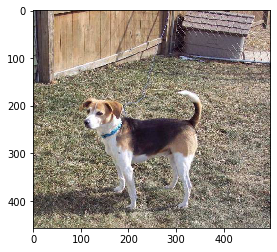

In [7]:
plt.imshow(image[0])

Generate batches of augmented images from the original image.

In [8]:
aug_iter = gen.flow(image)

The flow() function takes numpy data and generates batches of augmented data.

Now we’ll get ten samples of the augmented images.

In [9]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

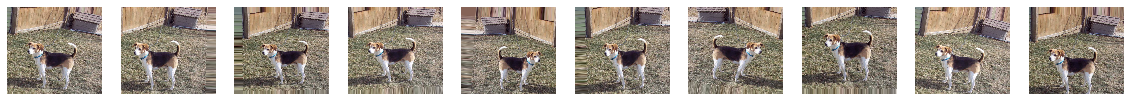

In [10]:
plotImages(aug_images)

These are ten images that have been augmented from the original image according to the parameters we passed to the ImageDataGenerator earlier.

We can see that some of the images have been flipped horizontally, some have slight color variation, some are tilted slightly to the left or right, and some are shifted down or up slightly.

### Save Augmented Data

Note, if you'd like to save these images so that you can add them to your training set, then to gen.flow(), you should also specify the parameter save_to_dir and set it equal to a valid location on disk.

You can optionally specify a prefix for which to prepend to file names of the saved augmented images, as well as optionally specify the file type as 'png' or 'jpeg' images. 'png' is the default.

     aug_iter = gen.flow(image, save_to_dir='data/dogs-vs-cats/train/dog', save_prefix='aug-image-', save_format='jpeg')

## Mapping Keras Labels To Image Classes

**When using a Keras ImageDataGenerator, how can we view the IDs or labels that have been assigned by Keras to the classes of the corresponding images?**

To understand this let us refresh our memory with some code.


we went through the set up to prepare a set of cat and dog image data for training a CNN.

<img src = "images/1.png">

We created ImageDataGenerators for our training, validation, and test sets and called flow_from_directory() on each of these. We pointed to the location on disk where the corresponding data resides.

We then utilized this plots() function, which allowed us to plot the images with the respective labels in our Jupyter notebook.


<img src = "images/2.png">


Using this function, we can see that since our data is categorical in nature, Keras has assigned the cat and dog classes these one-hot encoded vectors as its labels.

<img src = "images/3.png">

* For example, a cat is not referred to as “cat” but instead as [0,1]. Dog is referred to as [1,0].

* Since we’re only dealing with two classes here, we could have very well chosen to use binary classification, rather than categorical. If we used binary, then rather than the 2D labels that we have here, we would instead have 1D labels consisting of a 0 or a 1.

* We know from visually inspecting the output above which labels Keras has assigned to each of the categorical classes of cat and dog. What if we didn’t plot this, though? Then how will we know whether the label [0,1] corresponds to cat or dog?

* This then begs the question why do we even care?

* Recall that we previously called model.predict_generator() and passed in the test_batches and printed out the predictions.


<img src = "images/4.png">

In this case, all of our predictions were [0,1]. Note, this was prior to tuning our model to perform better, so here it was performing poorly and classifying everything as a cat.

If we didn’t print our batches ahead of time, though, we wouldn’t know that a [0,1] vector mapped to a cat, and these predictions wouldn’t make sense to us. We wouldn’t know if the model was predicting cats or dogs.

We need to be able to understand which label belongs to which class without having to plot the data. It is this idea that is being brought up and asked about on forums. How do we know which labels belong to which classes?

Luckily, we have a very straight forward way to do this.

There is an attribute called class_indices that we can access on an ImageDataGenerator, which will return the dictionary that contains the mapping from class names to class indices.

Let’s see what this looks like. We can call this on any of the ImageDatagenerators that we created, either test_batches, train_batches, or valid_batches.

We’ll demo this with test_batches.

Running the code test_batches.class_indices gives us the following output.

<img src = "images/5.png">

We see that the value 1 is assigned to cat, and the value 0 is assigned to dog.

But... our values are supposed to be one-hot encoded vectors, not just 0s and 1s. So, what's going on?

This output is actually giving us the index for where the corresponding value of a 1 resides in the one-hot encoded vectors.

So, it’s showing that a cat corresponds to a 1. By looking at an image of a cat in the plot we discussed above, we can see the value of the 1 in the one-hot encoded label is indeed the first index of that vector.

For a dog, the value of 1 is in the zeroth index, which is why the class index for a dog is 0.

If we had another category, lizard, then we would have another element showing that the class lizard corresponds to the index of 2. Then, all of our vectors would be length 3 for having three categorical classes.


<img src = "images/6.png">


In this case, the dog label would be [1,0,0]. The cat label would be [0,1,0]. The lizard label would be [0,0,1].

## Reproducible Results With Keras

Suppose we create a model and train it today, and then use that model to make predictions for image classification.

The model may tell us that it is 98% certain that the last image we passed it was an image of a dog. Since the image was indeed a dog, we think this is great and then close our program without saving a copy of our model on disk.

The next day, we open our program again, and we still have the code in place for the architecture of our model. We then compile the model and train it on the exact same data as we did yesterday for the same amount of epochs.

We then give it the same image to predict on, but this time, it tells us that it’s only 95% certain that our image is of a dog, whereas yesterday, it was 98%.

This illustrates varying results that we may get due to the random weight initialization that occurs when we train our model on the exact same training data.

This variation is fine, and it’s expected due to the random nature of weight initialization, as well as other configurations that are random by nature involved with our network.

Although this variation is expected, there are times when we want our model to reproduce the exact same results regardless of when we train it as long as we’re doing so on the same training data of course.

We can attain reproducibility with Random seeds

### Reproducibility With Random Seeds

Essentially, what we need to do is strip out the randomness that occurs during training. We can do this by setting a random seed to any given number before we build and train our model.

By setting a random seed, we’re forcing the “random” initialization of the weights to be generated based upon the seed we set. Then, going forward, as long as we’re using the same random seed, we can ensure that all the random variables in our model will always be generated in the exact same manner.

If we didn’t set the random seed, then each time we trained our model, the random variables would be generated differently.

For Keras, we’ll be generating a random seed for any random numbers that are generated by Python, NumPy, or TensorFlow. To do this, we’ll have to set the random seed for each of these libraries separately.

We want to be sure to set our random seeds right at the start of the program before we run any other code in regards to our model.

We first import numpy, tensorflow, and the Python library random.

In [11]:
import numpy as np
import tensorflow as tf
import random as rn

The piece of code below is necessary for any reproducibility for certain hash based algorithms, so we put this in directly underneath our import statements.

In [12]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [13]:
# random seed for numpy
np.random.seed(37)

In [14]:
# specify the random seed for Python using the random library.
rn.seed(1254)

In [15]:
# the same thing for TensorFlow.
tf.random.set_seed(89)

That’s all there is to it for getting reproducible results from our Keras model!

## Initializing And Accessing Bias In Keras

Below is an arbitrary small neural network with one hidden Dense layer containing 4 nodes, and an output layer with 2 nodes.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense

model = Sequential([
    Dense(4, input_shape=(1,), activation='relu', use_bias=True, bias_initializer='zeros'),
    Dense(2, activation='softmax')
])

The only two new parameter that has been added as compared to our previous models is **use_basis** and **bias_initalizer**.


**Parameter: use_bias**

In Keras, we specify whether or not we want a given layer to include biases for all of its neurons with the use_bias parameter. If we do want to include biases, we set the parameter value to True. Otherwise, we set it to False.

The default value is True, so if we don’t specify this parameter here at all, the layer will include bias terms by default.

**Parameter: bias_initializer**

Next, we have the bias_initializer parameter, which determines how the biases are initialized. This parameter determines how the biases are first set before we start training the model.

We are setting this parameter's value to the string 'zeros'. This means that all 4 biases in this layer will be set to a value of 0 before the model starts training.

'zeros' is actually the default value for the bias_initializer parameter.


### Observing Initialized Bias Terms

In [17]:
model.get_weights()

[array([[-0.55454445, -0.02694356, -0.24747324,  0.19590545]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[ 0.49596786, -0.736815  ],
        [ 0.20728207, -0.22432399],
        [ 0.13013887, -0.5781977 ],
        [-0.11257601,  0.01672506]], dtype=float32),
 array([0., 0.], dtype=float32)]

After being initialized, during training, these biases (and weights) will be updated as the model learns the optimized values for them. 

## Learnable Parameters ("Trainable Params") In A Keras Model

Creating a  very basic Keras Sequential model, which consists of an input layer with 2 input features, or 2 nodes, a single hidden layer with 3 nodes, and an output layer with 2 nodes. 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
model = Sequential([
        Dense(3, input_shape=(2,), activation='relu'),
        Dense(2, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


At the bottom of the summary, we have the total number of learnable parameters within the network displayed, which Keras refers to as Trainable params.

* The above model has a single hidden layer. For this layer we have 6 weights and 3 biases.
* the output layer contained 8 learnable parameters consisting of 6 weights, and 2 biases.

Thus the total parameters are 17 which is gievn in the below model.summary() code.

In [20]:
model.get_weights()

[array([[ 0.08327055,  0.09537017, -0.6525384 ],
        [ 0.36884415, -0.383074  ,  0.34086323]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[-0.41420782, -0.6075846 ],
        [ 0.02540624,  0.5752114 ],
        [ 0.70490575,  0.25025296]], dtype=float32),
 array([0., 0.], dtype=float32)]

So here, we first have our weights for the hidden layer, and recall, these are randomly initialized using Xavier or Glorot initialization by default in Keras. So we have these 6 random numbers here corresponding to the 6 weights we calculated for this layer.

Then, we have our 3 bias terms, which we previously learned were initialized to zeros by default. Note that the the sum of these two numbers does indeed add up to the 9 learnable parameters.

For last output layer we have 6 weights that have been randomly initialized, and we have 2 bias terms initialized to zeros. Summing these two numbers, we have 8 learnable parameters.

Adding 8 to 9, we have 17 total learnable parameters, which corresponds exactly to what Keras shows us for the total number of trainable params in the output above.

## Learnable Parameters ("Trainable Params") In A Keras Convolutional Neural Network

### Keras Model with Zero-Padding

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten , BatchNormalization , Conv2D, MaxPool2D
model = Sequential([
    Conv2D(
        2
        , kernel_size=(3,3)
        , input_shape=(20,20,3)
        , activation='relu'
        , padding='same'
    ),
    Conv2D(
        3
        , kernel_size=(3,3)
        , activation='relu'
        , padding='same'
    ),
    Flatten(),
    Dense(
        2, 
        activation='softmax'
    )
])


This model has an input layer consisting of images of size 20x20 with 3 color channels, a convolutional layer with 2 filters of size 3x3, a second convolutional layer with 3 filters of size 3x3, a Flatten layer to flatten the convolutional output, and then finally a Dense output layer with just 2 nodes.The padding here is assigned  = "same". To get a detail view about padding do watch [this](https://deeplizard.com/learn/video/qSTv_m-KFk0) video

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 2)         56        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 3)         57        
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2402      
Total params: 2,515
Trainable params: 2,515
Non-trainable params: 0
_________________________________________________________________


watch [how to calculate the number learnable parameters in a CNN  visit](https://deeplizard.com/learn/video/gmBfb6LNnZs)

in our first convolutional layer, we indeed calculated that there were 
* 56 learnable parameters, just as Keras is showing us in this output.
*  We also calculated that the second convolutional layer contained 57 learnable parameters and that 
* the output layer consisted of 2402 parameters, giving us a total 2515 learnable parameters in the entire network.

remember, we’re using zero padding here to maintain the dimensions of the images as they flow throughout the network. 

We needed to calculate how many inputs we had coming into this layer, which we calculated as 1200, as shown in the Output Shape column of the Flatten layer. The number 1200 was reached by multiplying 20x20x3, where 3 was the number of filters in the last convolutional layer.

The 20x20 is from the dimensions of the image data as it is output from the previous convolutional layer. We can see these dimensions as the output shape for the second convolutional layer. We then multiplied 1200 by the 2 nodes in the output layer and added the 2 bias terms, which gave us this result of 2402.

### Keras Model Without Zero-Padding

In [23]:
model = Sequential([
    Conv2D(2, kernel_size=(3,3), input_shape=(20,20,3), activation='relu'),
    Conv2D(3, kernel_size=(3,3), activation='relu'),
    Flatten(),
    Dense(2, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 18, 18, 2)         56        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 3)         57        
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1538      
Total params: 1,651
Trainable params: 1,651
Non-trainable params: 0
_________________________________________________________________


Here the toal params is 1,651 this is because:
    
The number of learnable parameters in the two convolutional layers stays the same, but we can see that the number of parameters in the last Dense layer has dropped considerably from 2402 to 1538.

That’s because, the dimensions of the images have shrunk in size to 16x16 by the time they’re leaving the last convolutional layer, so now, rather than multiplying 20x20x3, resulting in 1200, we’re multiplying 16x16x3, which gives us 768.

**So, just by removing zero padding from the convolutional layers, the number of total learnable parameters in the network has dropped from 2515 to 1651, a decrease of 34%.**

### Keras Model With Zero-Padding And Max-Pooling

In [25]:
model = Sequential([
    Conv2D(2, kernel_size=(3,3), input_shape=(20,20,3), activation='relu', padding='same'),
    Conv2D(3, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(2, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 20, 2)         56        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 3)         57        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 602       
Total params: 715
Trainable params: 715
Non-trainable params: 0
_________________________________________________________________


So now, rather than multiplying the original 20x20x3 dimensions when we flatten the convolutional output, we now multiply 10x10x3, as a result of max pooling.

This shrinks the learnable parameters drastically in our output layer from the original 2402 to 602, which contributes to a reduced number of total learnable parameters in the network from 2515 to 715.